In [2]:
# 1. Import library yang dibutuhkan
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Mengatur gaya visualisasi
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('viridis')

# 2. Memuat data mentah
file_path = 'data/BTC-USD_2020-01-01_to_2025-07-01.csv'
df = pd.read_csv(file_path, index_col=0)

# 3. Mendefinisikan dan menghapus semua baris sampah dari indeks
junk_rows_to_drop = ['Ticker', 'Date'] 
for label in junk_rows_to_drop:
    try:
        df.drop(label, inplace=True)
    except KeyError:
        pass # Mengabaikan jika label tidak ditemukan

# 4. Konversi kolom data menjadi tipe numerik
for col in df.columns:
    df[col] = pd.to_numeric(df[col], errors='coerce')

# 5. Menghapus baris yang mungkin datanya kosong setelah konversi
df.dropna(inplace=True)

# 6. Konversi indeks yang sudah bersih menjadi format Datetime
df.index = pd.to_datetime(df.index)

# 7. Memastikan data terurut berdasarkan tanggal
df.sort_index(inplace=True)

# 8. Verifikasi hasil akhir
print("✅ Informasi Dataset SETELAH PEMBERSIHAN FINAL:")
df.info()

print("\n✅ Statistik Deskriptif:")
print(df.describe())

print("\n✅ 5 Baris Pertama Data:")
df.head()

✅ Informasi Dataset SETELAH PEMBERSIHAN FINAL:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2008 entries, 2020-01-01 to 2025-06-30
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Close   2008 non-null   float64
 1   High    2008 non-null   float64
 2   Low     2008 non-null   float64
 3   Open    2008 non-null   float64
 4   Volume  2008 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 94.1 KB

✅ Statistik Deskriptif:
               Close           High            Low           Open  \
count    2008.000000    2008.000000    2008.000000    2008.000000   
mean    41702.321671   42529.402267   40742.300333   41654.709792   
std     26570.525485   27034.025262   26027.376140   26542.515217   
min      4970.788086    5331.833984    4106.980957    5002.578125   
25%     20625.011719   21120.606934   20207.600586   20599.279785   
50%     36763.480469   37637.529297   35383.732422   36701.085938   
75%     590

,Close,High,Low,Open,Volume
Price,,,,,
2020-01-01,7200.174316,7254.330566,7174.944336,7194.892090,18565664997
2020-01-02,6985.470215,7212.155273,6935.270020,7202.551270,20802083465
2020-01-03,7344.884277,7413.715332,6914.996094,6984.428711,28111481032
2020-01-04,7410.656738,7427.385742,7309.514160,7345.375488,18444271275
2020-01-05,7411.317383,7544.497070,7400.535645,7410.451660,19725074095


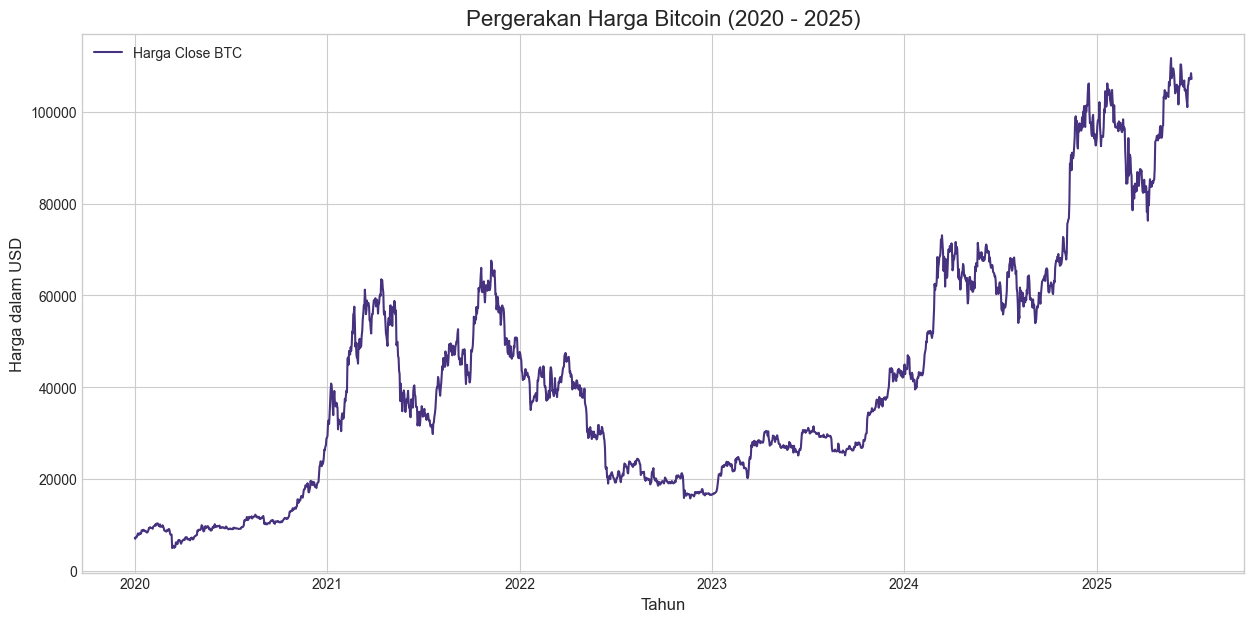

In [3]:
# VISUALISASI HARGA CLOSE

# Membuat area gambar yang lebih besar agar mudah dilihat
plt.figure(figsize=(15, 7))

# Plotting data harga penutupan (Close)
plt.plot(df['Close'], label='Harga Close BTC')

# Memberikan judul dan label pada sumbu
plt.title('Pergerakan Harga Bitcoin (2020 - 2025)', fontsize=16)
plt.xlabel('Tahun', fontsize=12)
plt.ylabel('Harga dalam USD', fontsize=12)
plt.legend()

# Menampilkan grid untuk kemudahan pembacaan
plt.grid(True)

# Menampilkan plot
plt.show()

In [4]:
# PRA-PEMROSESAN DATA

# 1. Import scaler dari scikit-learn
from sklearn.preprocessing import MinMaxScaler
import numpy as np

# 2. Hanya fokus pada harga penutupan ('Close')
# Membuat DataFrame baru yang hanya berisi kolom 'Close'
data_close = df[['Close']]

# 3. Membuat objek scaler
# Feature_range=(0, 1), yang berarti menskalakan data ke rentang antara 0 dan 1
scaler = MinMaxScaler(feature_range=(0, 1))

# 4. Melakukan scaling pada data
# .fit_transform() mempelajari skala data dan langsung mengubahnya
scaled_data = scaler.fit_transform(data_close)

# 5. Menampilkan 5 baris pertama dari data yang sudah di-scaling
print("Data setelah di-scaling (5 baris pertama):")
print(scaled_data[:5])

Data setelah di-scaling (5 baris pertama):
[[0.02089348]
 [0.0188813 ]
 [0.02224968]
 [0.02286609]
 [0.02287228]]


In [5]:
# MEMBAGI DATA

# Menentukan titik pembagian (80% untuk data training)
training_data_len = int(np.ceil(len(scaled_data) * 0.8))

# Membagi data
train_data = scaled_data[0:training_data_len, :]
test_data = scaled_data[training_data_len - 60:, :] # Kita mulai dari sebelum titik split untuk memastikan data uji punya cukup histori

# Menampilkan ukuran dari masing-masing set data
print(f"Jumlah data Latih (Training): {len(train_data)}")
print(f"Jumlah data Uji (Testing): {len(test_data)}")

Jumlah data Latih (Training): 1607
Jumlah data Uji (Testing): 461


In [6]:
# MEMBUAT X_TRAIN dan Y_TRAIN

# Membuat list kosong untuk menampung data
X_train = []
y_train = []

# Looping untuk membuat set data 60-hari
for i in range(60, len(train_data)):
    X_train.append(train_data[i-60:i, 0])
    y_train.append(train_data[i, 0])

# Konversi list menjadi format array NumPy yang dibutuhkan model
X_train, y_train = np.array(X_train), np.array(y_train)

# RESHAPE DATA: LSTM memerlukan input dalam format 3D
# [jumlah sampel, jumlah langkah waktu (timesteps), jumlah fitur]
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

# Menampilkan bentuk (shape) dari data yang sudah jadi
print("Shape dari X_train:", X_train.shape)
print("Shape dari y_train:", y_train.shape)

Shape dari X_train: (1547, 60, 1)
Shape dari y_train: (1547,)


In [7]:
# MEMBANGUN ARSITEKTUR LSTM

# 1. Import library dari TensorFlow Keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout

# 2. Membuat model Sequential
# Sequential adalah wadah kosong untuk kita tumpuk lapisan-lapisan neural network
model_lstm = Sequential()

# 3. Menambahkan lapisan-lapisan ke model
# Lapisan LSTM pertama
model_lstm.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model_lstm.add(Dropout(0.2)) # Mencegah overfitting

# Lapisan LSTM kedua
model_lstm.add(LSTM(units=50, return_sequences=False))
model_lstm.add(Dropout(0.2))

# Lapisan Dense (lapisan biasa)
model_lstm.add(Dense(units=25))
model_lstm.add(Dense(units=1)) # Lapisan output dengan 1 neuron untuk prediksi harga

# 4. Compile model
# Memberi tahu model bagaimana cara belajar (optimizer) dan cara mengukur kesalahan (loss)
model_lstm.compile(optimizer='adam', loss='mean_squared_error')

# 5. Menampilkan ringkasan arsitektur model
print("✅ Arsitektur Model LSTM Berhasil Dibuat:")
model_lstm.summary()

✅ Arsitektur Model LSTM Berhasil Dibuat:


c:\Users\ilman\.virtualenvs\Projects-xZET02ob\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 60, 50)         │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 60, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 25)             │         1,275 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 31,901 (124.61 KB)

 Trainable params: 31,901 (124.61 KB)

 Non-trainable params: 0 (0.00 B)

In [8]:
# MELATIH MODEL LSTM

print("Memulai proses pelatihan model LSTM...")

# Melatih model dengan data training
# batch_size: Berapa banyak sampel yang dilihat model sebelum update
# epochs: Berapa kali model melihat keseluruhan dataset training
history = model_lstm.fit(X_train, y_train, batch_size=32, epochs=25)

print("\n✅ Pelatihan model LSTM selesai!")

Memulai proses pelatihan model LSTM...
Epoch 1/25
49/49 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - loss: 0.0276
Epoch 2/25
49/49 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - loss: 0.0017
Epoch 3/25
49/49 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 0.0013
Epoch 4/25
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0011
Epoch 5/25
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.0012
Epoch 6/25
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0010
Epoch 7/25
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 9.0060e-04
Epoch 8/25
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 8.7018e-04
Epoch 9/25
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 8.9554e-04
Epoch 10/25
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 8.1707e-04
Epoch 11/25
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 7.7648e-04
Epoch 12/25
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 8.8440e-04
Epoch 13/25
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 7.4996e-04
Epoch 14/25
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 6.1883e-04


In [9]:
# MENGUJI MODEL LSTM

from sklearn.metrics import mean_squared_error, mean_absolute_error

# 1. Menyiapkan data uji (X_test dan y_test)
X_test = []
y_test = scaled_data[training_data_len:, :]
for i in range(60, len(test_data)):
    X_test.append(test_data[i-60:i, 0])

# Konversi X_test menjadi array NumPy dan reshape
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# 2. Melakukan prediksi
predictions = model_lstm.predict(X_test)

# 3. Mengembalikan data ke skala harga asli
predictions = scaler.inverse_transform(predictions)
y_test = scaler.inverse_transform(y_test)

# 4. Menghitung metrik evaluasi
rmse = np.sqrt(mean_squared_error(y_test, predictions))
mae = mean_absolute_error(y_test, predictions)

print(f"\n✅ Pengujian Selesai!")
print(f"Root Mean Squared Error (RMSE): ${rmse:,.2f}")
print(f"Mean Absolute Error (MAE):      ${mae:,.2f}")

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step

✅ Pengujian Selesai!
Root Mean Squared Error (RMSE): $2,899.14
Mean Absolute Error (MAE):      $2,174.16


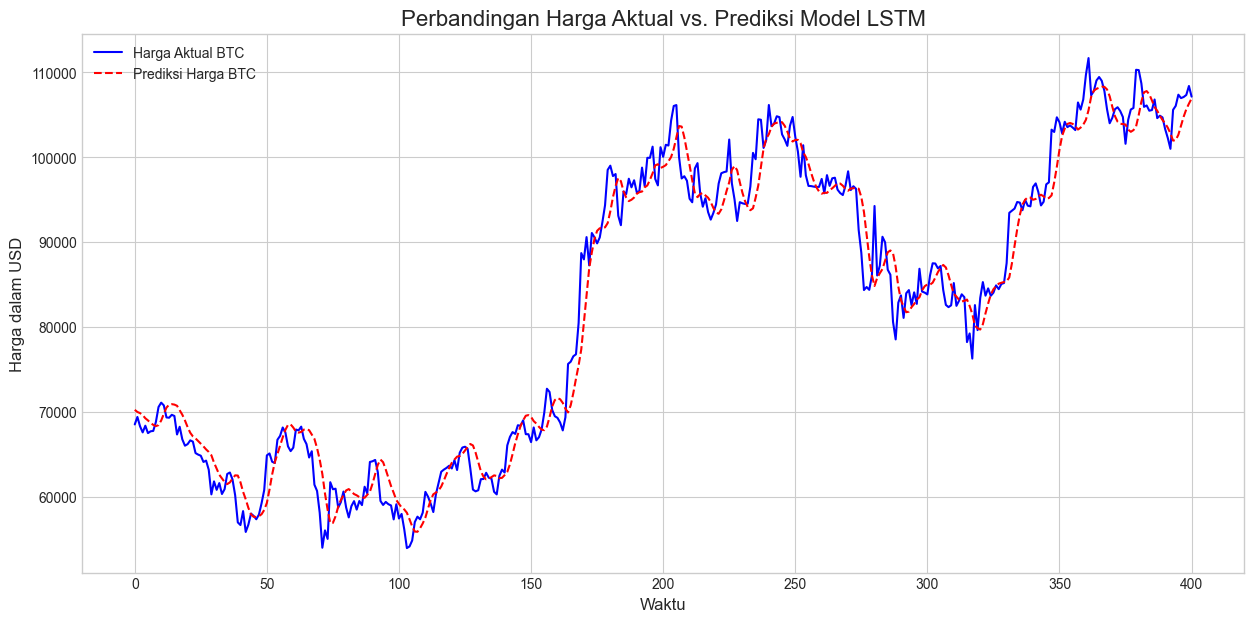

In [10]:
# VISUALISASI PREDIKSI vs DATA AKTUAL

# Membuat area gambar
plt.figure(figsize=(15, 7))

# Plot data aktual dan data prediksi
plt.plot(y_test, color='blue', label='Harga Aktual BTC')
plt.plot(predictions, color='red', linestyle='--', label='Prediksi Harga BTC')

# Memberikan judul dan label
plt.title('Perbandingan Harga Aktual vs. Prediksi Model LSTM', fontsize=16)
plt.xlabel('Waktu', fontsize=12)
plt.ylabel('Harga dalam USD', fontsize=12)
plt.legend()

# Menampilkan plot
plt.show()

In [11]:
# RANDOM FOREST

from sklearn.ensemble import RandomForestRegressor

# 1. Menyiapkan data untuk Random Forest (2D)
# Kita ubah kembali X_train dari 3D ke 2D
X_train_rf = np.reshape(X_train, (X_train.shape[0], X_train.shape[1]))

# 2. Membuat dan melatih model Random Forest
print("Memulai proses pelatihan model Random Forest...")
model_rf = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
model_rf.fit(X_train_rf, y_train)
print("✅ Pelatihan model Random Forest selesai!")

# 3. Menyiapkan data uji (X_test) untuk format 2D
X_test_rf = np.reshape(X_test, (X_test.shape[0], X_test.shape[1]))

# 4. Melakukan prediksi
rf_predictions = model_rf.predict(X_test_rf)

# 5. Mengembalikan data ke skala harga asli
# Kita harus reshape prediksi agar sesuai dengan input scaler
rf_predictions = scaler.inverse_transform(rf_predictions.reshape(-1, 1))

# 6. Menghitung metrik evaluasi
rf_rmse = np.sqrt(mean_squared_error(y_test, rf_predictions))
rf_mae = mean_absolute_error(y_test, rf_predictions)

print(f"\n✅ Pengujian Selesai!")
print(f"Hasil Model Random Forest:")
print(f"Root Mean Squared Error (RMSE): ${rf_rmse:,.2f}")
print(f"Mean Absolute Error (MAE):      ${rf_mae:,.2f}")

Memulai proses pelatihan model Random Forest...
✅ Pelatihan model Random Forest selesai!

✅ Pengujian Selesai!
Hasil Model Random Forest:
Root Mean Squared Error (RMSE): $22,732.06
Mean Absolute Error (MAE):      $17,263.62


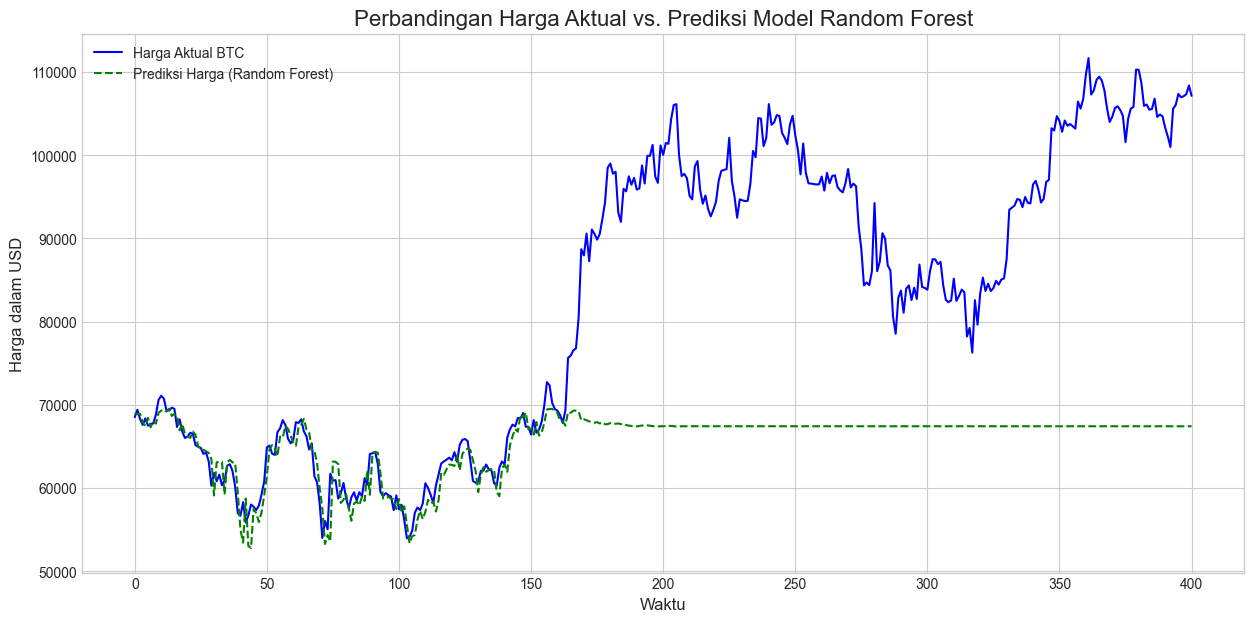

In [12]:
# VISUALISASI PREDIKSI RANDOM FOREST

# Membuat area gambar
plt.figure(figsize=(15, 7))

# Plot data aktual dan data prediksi
plt.plot(y_test, color='blue', label='Harga Aktual BTC')
plt.plot(rf_predictions, color='green', linestyle='--', label='Prediksi Harga (Random Forest)')

# Memberikan judul dan label
plt.title('Perbandingan Harga Aktual vs. Prediksi Model Random Forest', fontsize=16)
plt.xlabel('Waktu', fontsize=12)
plt.ylabel('Harga dalam USD', fontsize=12)
plt.legend()

# Menampilkan plot
plt.show()

In [13]:
# Menyimpan model dalam format .keras
model_lstm.save('models/lstm_model.keras')

print("✅ Model berhasil disimpan dalam format baru di: models/lstm_model.keras")

✅ Model berhasil disimpan dalam format baru di: models/lstm_model.keras


In [ ]:
# Menyimpan HANYA BOBOT model
model_lstm.save_weights('models/lstm_model_weights.weights.h5')

print("✅ Bobot model berhasil disimpan di: models/lstm_model_weights.weights.h5")

In [14]:
# MENYIMPAN MODEL LSTM DAN SCALER
import joblib
import os # Tambahkan baris ini

# Membuat folder 'models' jika belum ada
if not os.path.exists('models'):
    os.makedirs('models')

# Menyimpan model LSTM
model_lstm.save('models/lstm_model.h5')

# Menyimpan scaler
joblib.dump(scaler, 'models/scaler.pkl')

print("✅ Model dan Scaler berhasil disimpan di dalam folder 'models'!")

✅ Model dan Scaler berhasil disimpan di dalam folder 'models'!


In [15]:
# MENYIMPAN MODEL RANDOM FOREST

# Menyimpan model Random Forest
joblib.dump(model_rf, 'models/rf_model.pkl')

print("✅ Model Random Forest berhasil disimpan di 'models/rf_model.pkl'")

✅ Model Random Forest berhasil disimpan di 'models/rf_model.pkl'
